In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nnunetv2 SimpleITK nibabel pandas numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB

In [6]:
import os
# Set nnUNet paths
base_path = '/content/drive/MyDrive/pancreas_project'
os.environ['nnUNet_raw'] = f'{base_path}/nnUNet_raw'
os.environ['nnUNet_preprocessed'] = f'{base_path}/nnUNet_preprocessed'
os.environ['nnUNet_results'] = f'{base_path}/nnUNet_results'
print("Paths set successfully!")

Paths set successfully!


In [7]:
# Import necessary libraries
import torch
import numpy as np
from pathlib import Path
import nibabel as nib
import shutil
import json
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.cuda import amp
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer
from nnunetv2.paths import nnUNet_preprocessed, nnUNet_results
from nnunetv2.utilities.default_n_proc_DA import get_allowed_n_proc_DA

%matplotlib inline

In [4]:
# Check GPU availability
!nvidia-smi

print("\nPyTorch GPU Status:")
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found!")

Sun Jan 26 00:01:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **nnUNetV2 Data Organization**

In [5]:
def organize_data_for_nnunet():
    base_path = Path('/content/drive/MyDrive/pancreas_project')
    dataset_name = 'Dataset001'  # Keep original name
    nnunet_raw_data_path = base_path / 'nnUNet_raw' / dataset_name

    # Create all necessary directories including validation folders
    for folder in ['imagesTr', 'labelsTr', 'imagesTs', 'imagesVal', 'labelsVal']:
        (nnunet_raw_data_path / folder).mkdir(parents=True, exist_ok=True)

    # Create dataset.json
    dataset_json = {
        "name": "Pancreas",
        "description": "Pancreas Segmentation Dataset",
        "tensorImageSize": "3D",
        "channel_names": {
            "0": "CT"
        },
        "labels": {
            "background": 0,
            "pancreas": 1,
            "lesion": 2
        },
        "class_types": {
            "subtype0": 0,
            "subtype1": 1,
            "subtype2": 2
        },
        "numTraining": 0,
        "numValidation": 0,
        "numTest": 0,
        "file_ending": ".nii.gz",
        "training": [],
        "validation": [],
        "test": []
    }

    subtype_mapping = {}

    # Process training data
    for subtype in ['subtype0', 'subtype1', 'subtype2']:
        train_path = base_path / 'data' / 'train' / subtype
        if train_path.exists():
            for file in sorted(train_path.glob('*_0000.nii.gz')):
                case_id = file.stem.split('_0000')[0]
                mask_file = train_path / f"{case_id}.nii.gz"

                if not mask_file.exists():
                    print(f"Warning: Mask file not found for training case '{case_id}'. Skipping...")
                    continue

                try:
                    shutil.copy2(file, nnunet_raw_data_path / 'imagesTr' / file.name)

                    mask = nib.load(mask_file)
                    mask_data = np.round(mask.get_fdata()).astype(np.uint8)
                    mask_data = np.clip(mask_data, 0, 2)
                    new_mask = nib.Nifti1Image(mask_data, mask.affine)
                    nib.save(new_mask, nnunet_raw_data_path / 'labelsTr' / f"{case_id}.nii.gz")

                    dataset_json["training"].append({
                        "image": f"./imagesTr/{file.name}",
                        "label": f"./labelsTr/{case_id}.nii.gz"
                    })

                    subtype_mapping[case_id] = {
                        "subtype": int(subtype[-1]),
                        "split": "train"
                    }

                except Exception as e:
                    print(f"Error processing training case '{case_id}': {e}")

    # Process validation data - store in separate folders
    validation_cases = []
    for subtype in ['subtype0', 'subtype1', 'subtype2']:
        val_path = base_path / 'data' / 'validation' / subtype
        if val_path.exists():
            for file in sorted(val_path.glob('*_0000.nii.gz')):
                case_id = file.stem.split('_0000')[0]
                mask_file = val_path / f"{case_id}.nii.gz"

                if not mask_file.exists():
                    print(f"Warning: Mask file not found for validation case '{case_id}'. Skipping...")
                    continue

                try:
                    # Copy to validation folders
                    shutil.copy2(file, nnunet_raw_data_path / 'imagesVal' / file.name)

                    mask = nib.load(mask_file)
                    mask_data = np.round(mask.get_fdata()).astype(np.uint8)
                    mask_data = np.clip(mask_data, 0, 2)
                    new_mask = nib.Nifti1Image(mask_data, mask.affine)
                    nib.save(new_mask, nnunet_raw_data_path / 'labelsVal' / f"{case_id}.nii.gz")

                    dataset_json["validation"].append({
                        "image": f"./imagesVal/{file.name}",
                        "label": f"./labelsVal/{case_id}.nii.gz"
                    })

                    validation_cases.append(case_id)
                    subtype_mapping[case_id] = {
                        "subtype": int(subtype[-1]),
                        "split": "validation"
                    }

                except Exception as e:
                    print(f"Error processing validation case '{case_id}': {e}")

    # Process test data
    test_path = base_path / 'data' / 'test'
    if test_path.exists():
        for file in sorted(test_path.glob('*_0000.nii.gz')):
            try:
                shutil.copy2(file, nnunet_raw_data_path / 'imagesTs' / file.name)
                dataset_json["test"].append({"image": f"./imagesTs/{file.name}"})
            except Exception as e:
                print(f"Error processing test file '{file}': {e}")

    # Update dataset.json
    dataset_json["numTraining"] = len(dataset_json["training"])
    dataset_json["numValidation"] = len(dataset_json["validation"])
    dataset_json["numTest"] = len(dataset_json["test"])

    # Save dataset.json
    with open(nnunet_raw_data_path / 'dataset.json', 'w') as f:
        json.dump(dataset_json, f, indent=4)

    # Save subtype mapping with validation cases
    with open(nnunet_raw_data_path / 'subtype_mapping.json', 'w') as f:
        json.dump({
            "mapping": subtype_mapping,
            "validation_cases": validation_cases
        }, f, indent=4)


    print("\nData Organization Summary:")
    print(f"Training cases: {dataset_json['numTraining']}")
    print(f"Validation cases: {dataset_json['numValidation']}")
    print(f"Test cases: {dataset_json['numTest']}")

    return nnunet_raw_data_path, subtype_mapping

if __name__ == "__main__":
    nnunet_dataset_path, metadata = organize_data_for_nnunet()

    # Verify the file structure
    print("\nVerifying file structure:")
    print(f"Training images: {len(list((nnunet_dataset_path / 'imagesTr').glob('*.nii.gz')))}")
    print(f"Training labels: {len(list((nnunet_dataset_path / 'labelsTr').glob('*.nii.gz')))}")
    print(f"Validation images: {len(list((nnunet_dataset_path / 'imagesVal').glob('*.nii.gz')))}")
    print(f"Validation labels: {len(list((nnunet_dataset_path / 'labelsVal').glob('*.nii.gz')))}")
    print(f"Test images: {len(list((nnunet_dataset_path / 'imagesTs').glob('*.nii.gz')))}")


Data Organization Summary:
Training cases: 252
Validation cases: 36
Test cases: 72

Verifying file structure:
Training images: 252
Training labels: 252
Validation images: 36
Validation labels: 36
Test images: 72


In [7]:
# Clone the nnUNet repository
#!git clone https://github.com/MIC-DKFZ/nnUNet.git

In [8]:
# Change directory to the cloned repository
#%cd /content/drive/MyDrive/pancreas_project/nnUNet

# Install nnUNet in editable mode
#!pip install -e .

In [ ]:
# Data preprocessing and planning with ResEncM planner.
!nnUNetv2_plan_and_preprocess -d 001 -pl nnUNetPlannerResEncM

Fingerprint extraction...
Dataset001
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 252/252 [01:05<00:00,  3.84it/s]
Experiment planning...
Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [ 59. 118. 181.], 3d_lowres: [59, 118, 181]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 134, 'patch_size': (128, 192), 'median_image_size_in_voxels': array([118., 181.]), 'spacing': array([0.73046875, 0.73046875]), 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_seg_kwargs': {'is_seg': True, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_probabilities': 'resample_d

In [ ]:
# Clone the nnUNet repository
#!git clone https://github.com/MIC-DKFZ/nnUNet.git

In [ ]:
# Change directory to the cloned repository
#%cd $base_path

# Install nnUNet in editable mode
#!pip install -e .

In [ ]:
 # %cd nnUNet
# !pip install -e .

In [6]:
!nnUNetv2_train --help

usage: nnUNetv2_train [-h] [-tr TR] [-p P] [-pretrained_weights PRETRAINED_WEIGHTS]
                      [-num_gpus NUM_GPUS] [--use_compressed] [--npz] [--c] [--val] [--val_best]
                      [--disable_checkpointing] [-device DEVICE]
                      dataset_name_or_id configuration fold

positional arguments:
  dataset_name_or_id    Dataset name or ID to train with
  configuration         Configuration that should be trained
  fold                  Fold of the 5-fold cross-validation. Should be an int between 0 and 4.

options:
  -h, --help            show this help message and exit
  -tr TR                [OPTIONAL] Use this flag to specify a custom trainer. Default:
                        nnUNetTrainer
  -p P                  [OPTIONAL] Use this flag to specify a custom plans identifier. Default:
                        nnUNetPlans
  -pretrained_weights PRETRAINED_WEIGHTS
                        [OPTIONAL] path to nnU-Net checkpoint file to be used as pretrained mo

In [ ]:
# Training Dataset001 with 3D full resolution using ResEncM planner
!nnUNetv2_train 001 3d_fullres 0 -tr nnUNetTrainer -p nnUNetResEncUNetMPlans --c

Using device: cuda:0
/usr/local/lib/python3.11/dist-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-01-24 23:22:59.669746: Using torch.compile...
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packag

# **Running validation inference**

In [10]:
# Using trained model to predict segmentation masks on validation images,
!nnUNetv2_predict -i /content/drive/MyDrive/pancreas_project/nnUNet_raw/Dataset001/imagesVal \
                 -o /content/drive/MyDrive/pancreas_project/nnUNet_results/Dataset001/inference_output \
                 -d 001 \
                 -c 3d_fullres \
                 -tr nnUNetTrainer \
                 -p nnUNetResEncUNetMPlans \
                 -f 0 \
                 -chk checkpoint_best.pth


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

/usr/local/lib/python3.11/dist-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

## **Running Test inference**

In [11]:
# Predicting segmentation masks on test images using trained model
!nnUNetv2_predict -i /content/drive/MyDrive/pancreas_project/nnUNet_raw/Dataset001/imagesTs \
                 -o /content/drive/MyDrive/pancreas_project/nnUNet_results/Dataset001/test_output \
                 -d 001 \
                 -c 3d_fullres \
                 -tr nnUNetTrainer \
                 -p nnUNetResEncUNetMPlans \
                 -f 0 \
                 -chk checkpoint_best.pth


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

/usr/local/lib/python3.11/dist-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

# **Visualizing Validation Results**

Selected slice index: 30
Image slice min, max: 0.009567406729228657, 0.6699778744182497
Ground truth unique values: [0. 1. 2.]
Predicted mask unique values: [0. 1. 2.]


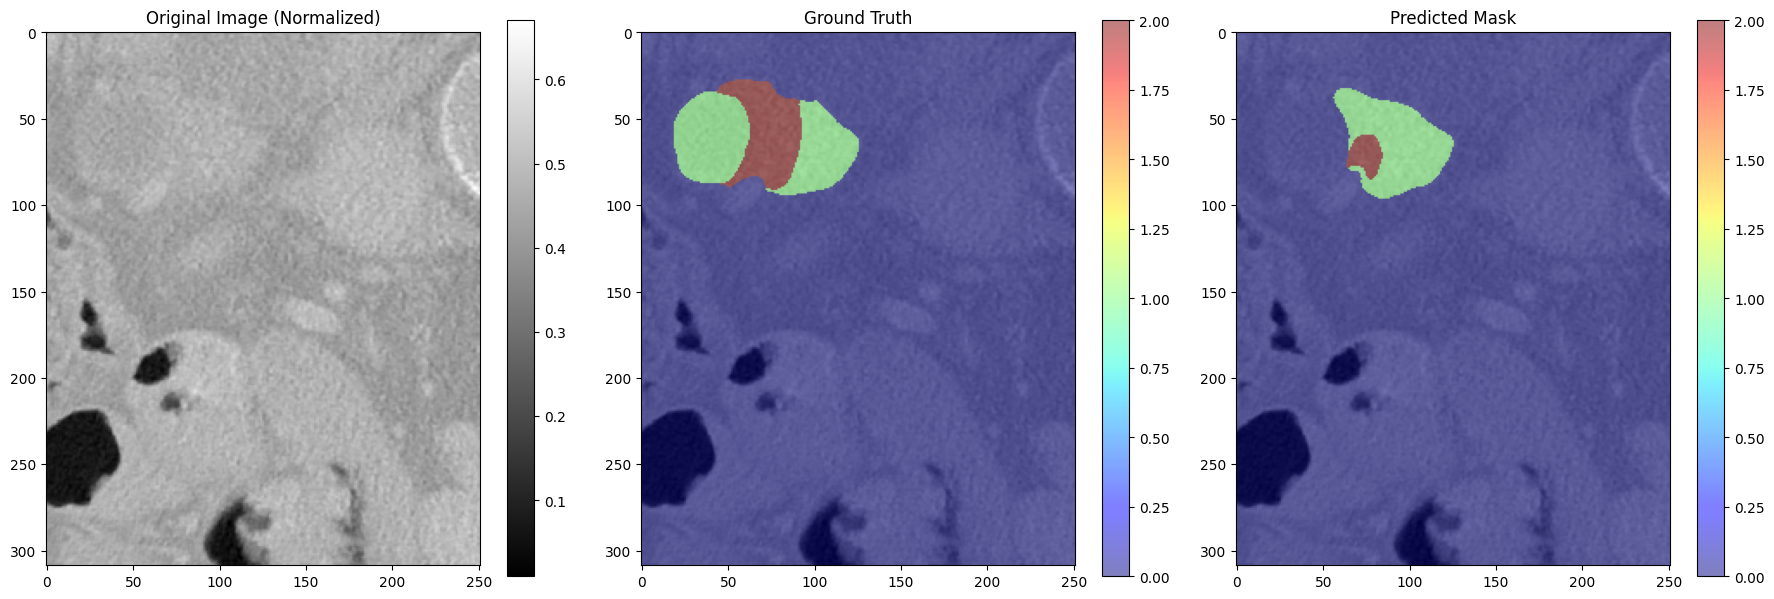

In [13]:
# File paths
image_path = "/content/drive/MyDrive/pancreas_project/nnUNet_raw/Dataset001/imagesVal/quiz_0_168_0000.nii.gz"
ground_truth_path = "/content/drive/MyDrive/pancreas_project/nnUNet_raw/Dataset001/labelsVal/quiz_0_168.nii.gz"
predicted_mask_path = "/content/drive/MyDrive/pancreas_project/nnUNet_results/Dataset001/inference_output/quiz_0_168.nii.gz"

# Load the image, ground truth, and predicted mask
image = nib.load(image_path).get_fdata()
ground_truth = nib.load(ground_truth_path).get_fdata()
predicted_mask = nib.load(predicted_mask_path).get_fdata()

# Normalize image to [0, 1] for display
image_min, image_max = np.min(image), np.max(image)
image = (image - image_min) / (image_max - image_min)

# Select a slice with meaningful content
slice_idx = image.shape[2] // 2  # Middle slice
if np.sum(image[:, :, slice_idx]) == 0:  # If slice is empty, find another slice
    slice_idx = next((i for i in range(image.shape[2]) if np.sum(image[:, :, i]) > 0), slice_idx)

print(f"Selected slice index: {slice_idx}")
print(f"Image slice min, max: {np.min(image[:, :, slice_idx])}, {np.max(image[:, :, slice_idx])}")
print(f"Ground truth unique values: {np.unique(ground_truth[:, :, slice_idx])}")
print(f"Predicted mask unique values: {np.unique(predicted_mask[:, :, slice_idx])}")

# Ensure there is actual data in the selected slice
assert np.max(image[:, :, slice_idx]) > 0, "Selected slice has no meaningful content."
assert np.max(ground_truth[:, :, slice_idx]) > 0, "Ground truth has no meaningful content."
assert np.max(predicted_mask[:, :, slice_idx]) > 0, "Predicted mask has no meaningful content."


plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image (Normalized)")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.colorbar()

# Ground Truth with Overlay
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.imshow(ground_truth[:, :, slice_idx], cmap="jet", alpha=0.5)
plt.colorbar()

# Predicted Mask with Overlay
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.imshow(predicted_mask[:, :, slice_idx], cmap="jet", alpha=0.5)
plt.colorbar()

plt.tight_layout()
plt.show()

# **Computing DSC scores**

In [14]:
def dice_coefficient(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    sum_labels = np.sum(y_true == class_id) + np.sum(y_pred == class_id)
    dice = 2 * intersection / sum_labels if sum_labels > 0 else 0
    return dice

for class_id in [1, 2]:
    dice = dice_coefficient(ground_truth, predicted_mask, class_id)
    print(f"Dice coefficient for class {class_id}: {dice:.4f}")

Dice coefficient for class 1: 0.8678
Dice coefficient for class 2: 0.3893


# **Visualizing Test Predictions**

Selected slice index: 60
Image slice min, max: 0.09296481244104558, 0.7826633139155996
Predicted mask unique values: [0. 1.]


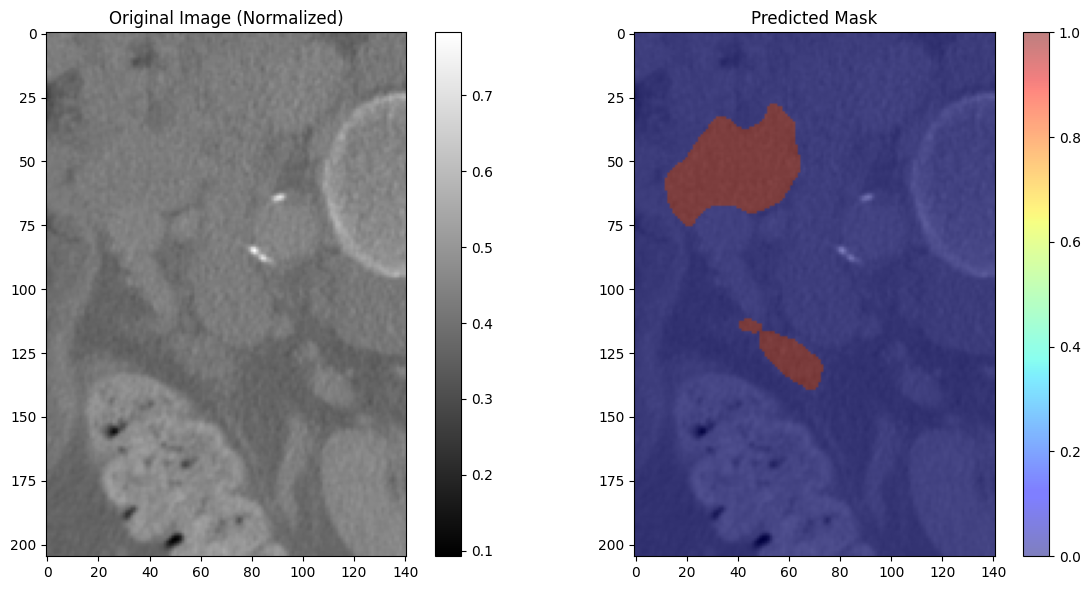

In [19]:
# File paths
image_path = "/content/drive/MyDrive/pancreas_project/nnUNet_raw/Dataset001/imagesTs/quiz_047_0000.nii.gz"
predicted_mask_path = "/content/drive/MyDrive/pancreas_project/nnUNet_results/Dataset001/test_output/quiz_047.nii.gz"

# Load the image and predicted mask
image = nib.load(image_path).get_fdata()
predicted_mask = nib.load(predicted_mask_path).get_fdata()

# Normalize image to [0, 1] for display
image_min, image_max = np.min(image), np.max(image)
image = (image - image_min) / (image_max - image_min)

# Select a slice with meaningful content
slice_idx = image.shape[2] // 2  # Middle slice
if np.sum(image[:, :, slice_idx]) == 0:  # If slice is empty, find another slice
    slice_idx = next((i for i in range(image.shape[2]) if np.sum(image[:, :, i]) > 0), slice_idx)

print(f"Selected slice index: {slice_idx}")
print(f"Image slice min, max: {np.min(image[:, :, slice_idx])}, {np.max(image[:, :, slice_idx])}")
print(f"Predicted mask unique values: {np.unique(predicted_mask[:, :, slice_idx])}")

# Ensure there is actual data in the selected slice
assert np.max(image[:, :, slice_idx]) > 0, "Selected slice has no meaningful content."
assert np.max(predicted_mask[:, :, slice_idx]) > 0, "Predicted mask has no meaningful content."

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image (Normalized)")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.colorbar()

# Predicted Mask with Overlay
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.imshow(predicted_mask[:, :, slice_idx], cmap="jet", alpha=0.5)
plt.colorbar()

plt.tight_layout()
plt.show()


# **Computing Class Distribution**

In [20]:
def compute_class_distribution(y_pred):
    """
    Compute the distribution of predicted classes.
    This provides insights into the frequency of each class in the predictions.
    """
    unique_classes, counts = np.unique(y_pred, return_counts=True)
    distribution = {class_id: count for class_id, count in zip(unique_classes, counts)}
    return distribution

# Predicted mask (assumes predicted_mask is already loaded)
predicted_mask = nib.load("/content/drive/MyDrive/pancreas_project/nnUNet_results/Dataset001/test_output/quiz_047.nii.gz").get_fdata()

# Analyze class distribution in the predicted mask
distribution = compute_class_distribution(predicted_mask)

# Display class distribution
print("Class distribution in the predicted mask:")
for class_id, count in distribution.items():
    print(f"Class {int(class_id)}: {count} pixels")

# Optional: Compute Dice coefficient if pseudo-ground truth is available
def dice_coefficient(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    sum_labels = np.sum(y_true == class_id) + np.sum(y_pred == class_id)
    dice = 2 * intersection / sum_labels if sum_labels > 0 else 0
    return dice

Class distribution in the predicted mask:
Class 0: 3223157 pixels
Class 1: 242699 pixels
Class 2: 2744 pixels


In [9]:
!export nnUNetv2_dataloader_num_workers=2

# **Multi-Task Model Training Configuration**

In [11]:
# Define paths
base_path = Path('/content/drive/MyDrive/pancreas_project')
dataset_path = base_path / '/content/drive/MyDrive/pancreas_project/nnUNet_results/Dataset001/nnUNetTrainer__nnUNetResEncUNetMPlans__3d_fullres/dataset.json'
plans_path = base_path / '/content/drive/MyDrive/pancreas_project/nnUNet_results/Dataset001/nnUNetTrainer__nnUNetResEncUNetMPlans__3d_fullres/plans.json'

# Load dataset metadata
with open(dataset_path, 'r') as f:
    metadata = json.load(f)
print("Dataset metadata:", metadata)

# Load plans.json
with open(plans_path, 'r') as f:
    plans = json.load(f)
print("Plans:", plans)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the trainer
trainer = nnUNetTrainer(
    plans=plans,
    configuration="3d_fullres",  # Match the configuration from plans.json
    fold=0,  # Specify the fold to train
    dataset_json=metadata,
    unpack_dataset=True,  # Set to False if the dataset is already unpacked
    device=device
)

# Override default parameters
trainer.num_epochs = 100
trainer.batch_size = 2
trainer.patch_size = (96, 192, 192)
trainer.learning_rate = 0.0001
trainer.data_augmentation = True
trainer.checkpoint_interval = 1

# Start training
trainer.run_training()

Dataset metadata: {'name': 'Pancreas', 'description': 'Pancreas Segmentation Dataset', 'tensorImageSize': '3D', 'channel_names': {'0': 'CT'}, 'labels': {'background': 0, 'pancreas': 1, 'lesion': 2}, 'class_types': {'subtype0': 0, 'subtype1': 1, 'subtype2': 2}, 'numTraining': 252, 'numValidation': 36, 'numTest': 72, 'file_ending': '.nii.gz', 'training': [{'image': './imagesTr/quiz_0_041_0000.nii.gz', 'label': './labelsTr/quiz_0_041.nii.gz'}, {'image': './imagesTr/quiz_0_060_0000.nii.gz', 'label': './labelsTr/quiz_0_060.nii.gz'}, {'image': './imagesTr/quiz_0_066_0000.nii.gz', 'label': './labelsTr/quiz_0_066.nii.gz'}, {'image': './imagesTr/quiz_0_070_0000.nii.gz', 'label': './labelsTr/quiz_0_070.nii.gz'}, {'image': './imagesTr/quiz_0_077_0000.nii.gz', 'label': './labelsTr/quiz_0_077.nii.gz'}, {'image': './imagesTr/quiz_0_117_0000.nii.gz', 'label': './labelsTr/quiz_0_117.nii.gz'}, {'image': './imagesTr/quiz_0_126_0000.nii.gz', 'label': './labelsTr/quiz_0_126.nii.gz'}, {'image': './imagesTr

/usr/local/lib/python3.11/dist-packages/nnunetv2/utilities/get_network_from_plans.py:20: UserWarning: Network class dual_head_unet.DualHeadUNet not found. Attempting to locate it within dynamic_network_architectures.architectures...
  warnings.warn(f'Network class {network_class} not found. Attempting to locate it within '


ImportError: Network class could not be found, please check/correct your plans file